# Plot persistent scores and betti curves

## Initialization

In [1]:
# General
import os, glob, time, pickle
from copy import deepcopy
from functools import partial

# For progress + multipleprocessing 
from p_tqdm import p_map
from tqdm.notebook import tqdm

# General computation
import numpy as np 
from sklearn.metrics import pairwise_distances as pw_dist
from scipy.spatial.distance import squareform
from scipy.stats import entropy

# TDA packages
import gudhi as gd

# Import from src 
from src.utils import *
from src.tda import *


In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager
import seaborn as sns

%matplotlib inline

rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

# use one of the available styles 
plt.style.use('seaborn-notebook')

# further customization
rcParams['font.family'] = 'FreeSans'
rcParams['font.size'] = 15

rcParams['axes.titlesize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2 

rcParams['mathtext.fontset'] = 'cm' 
rcParams['mathtext.rm'] = 'serif'
rcParams['figure.dpi'] = 200


## Compare with `varinfo` between nulls and data (edge density) of persistent scores

In [3]:
proc_path = 'data/processed/'
sum_path = 'data/summary/'

pershom_files = dict(
    block = 'block-pershom.pkl',
    geom = 'geom-pershom.pkl',
    og_corrdist = 'multisensory-pershom-original-withedgedensity-corr_dist.pkl',
    shuff_corrdist = 'multisensory-pershom-shuffled-withedgedensity-corr_dist.pkl',
    og_varinfo = 'multisensory-pershom-original-withedgedensity-var_info.pkl', 
    shuff_varinfo = 'multisensory-pershom-shuffled-withedgedensity-var_info.pkl'
)

pershom_data = {}
for k,v in pershom_files.items():
    with open(proc_path + v, 'rb') as f: 
        pershom_data[k] = pickle.load(f)

In [4]:
{k: list(v['barfeats'].keys()) for k,v in pershom_data.items()}

{'block': ['assort', 'disassort', 'core', 'discore'],
 'geom': [2, 3, 5, 7, 10, 20, 40, 60, 78],
 'og_corrdist': ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'],
 'shuff_corrdist': ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'],
 'og_varinfo': ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'],
 'shuff_varinfo': ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS']}

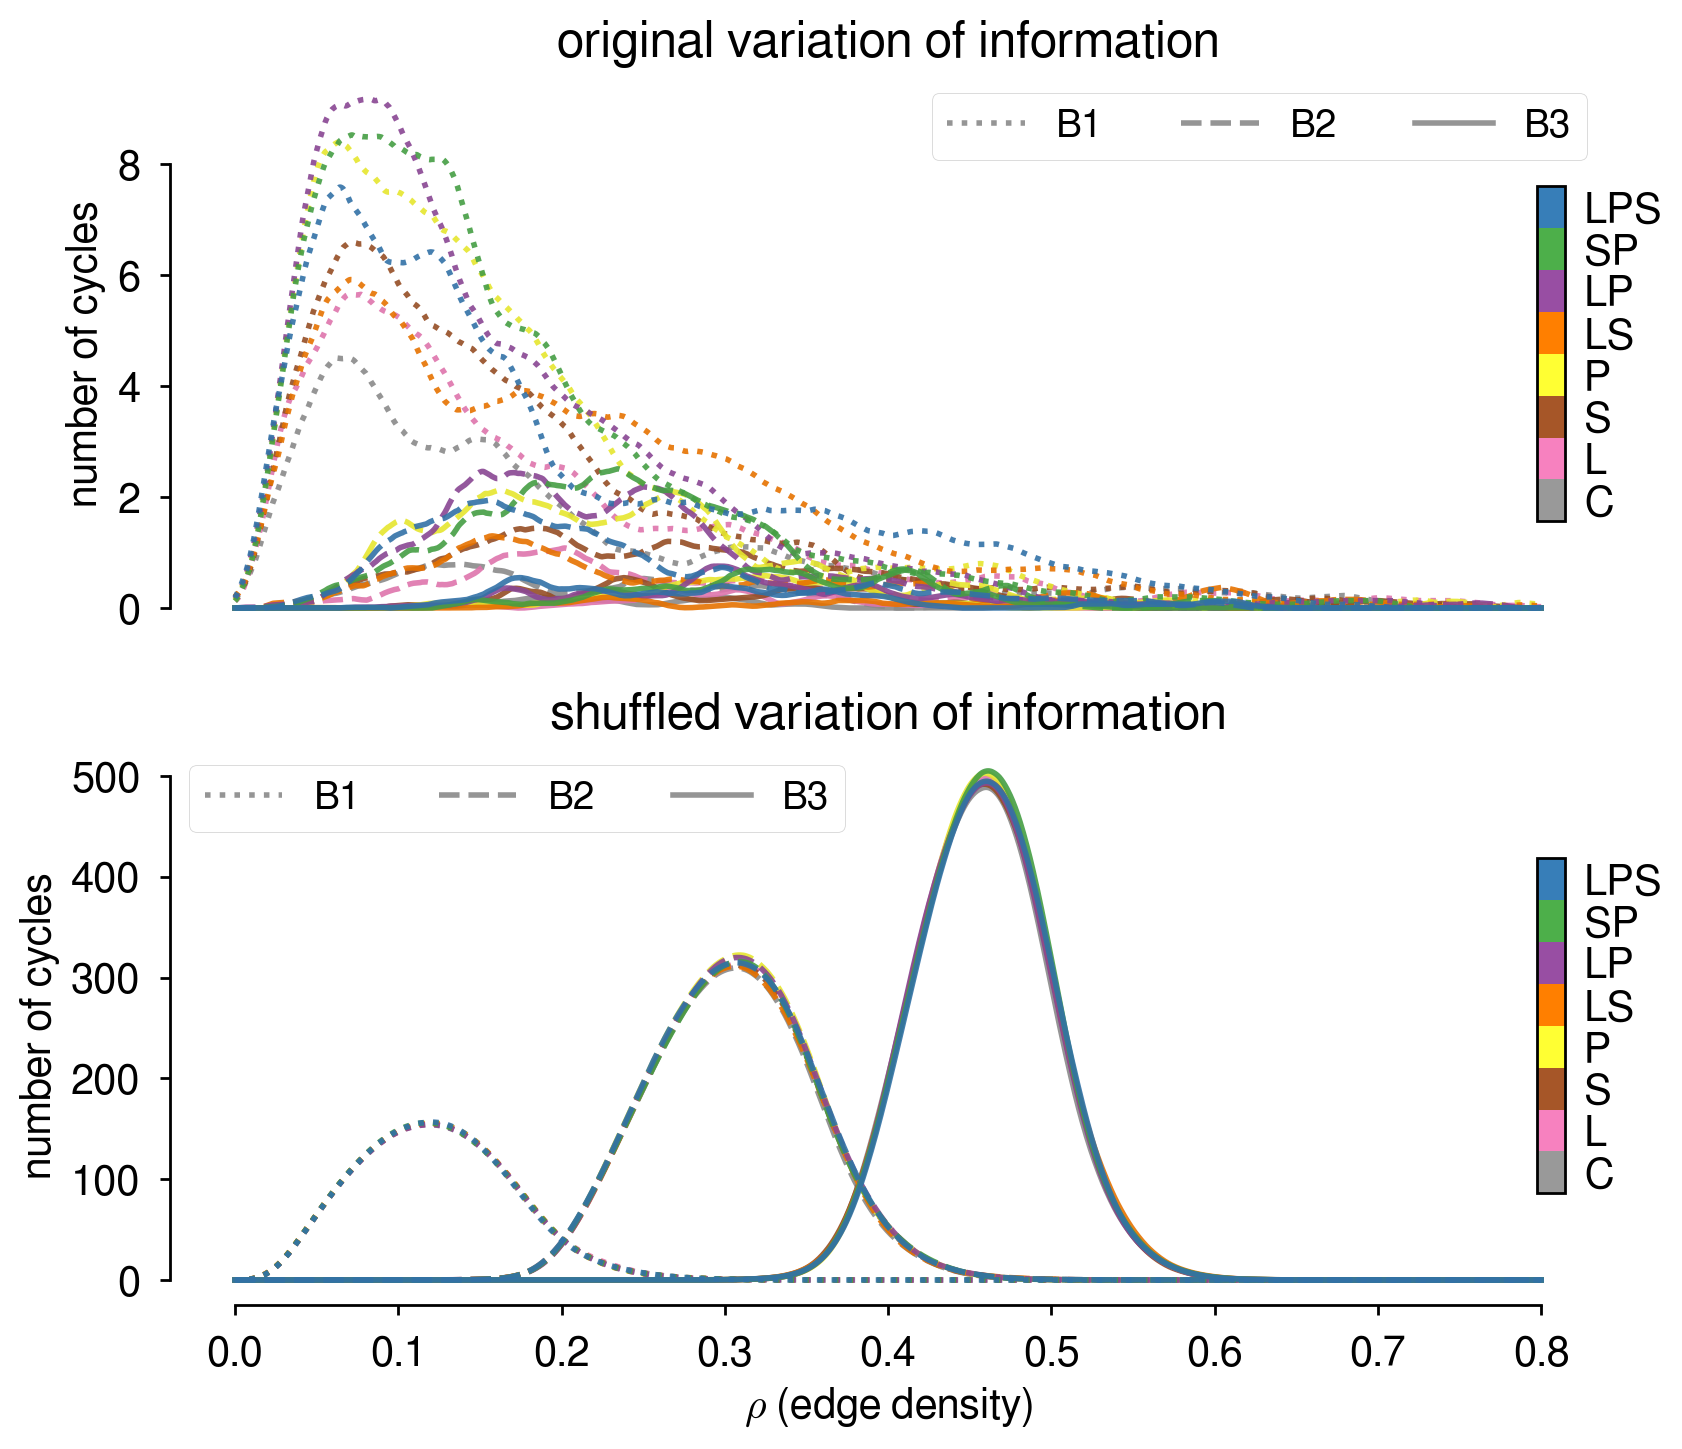

In [139]:
cmap_types = dict(
    block = 'Set2',
    geom = 'viridis',
    og_corrdist = 'Set1_r',
    shuff_corrdist = 'Set1_r',
    og_varinfo = 'Set1_r', 
    shuff_varinfo = 'Set1_r'
)
var_names = dict(
    block = '',
    geom = 'd=',
    og_corrdist = '',
    shuff_corrdist = '',
    og_varinfo = '', 
    shuff_varinfo = ''
)
title_names = dict(
    block = 'block model',
    geom = 'geometric model',
    og_corrdist = 'original correlation distance',
    shuff_corrdist = 'shuffled correlation distance',
    og_varinfo = 'original variation of information', 
    shuff_varinfo = 'shuffled variation of information'
)
betti_styles = {'B1': ':', 'B2': '--', 'B3': '-'}

data_pairs_set = [
    ['og_varinfo', 'shuff_varinfo'],
    ['og_corrdist', 'shuff_corrdist'],
    ['og_varinfo', 'geom'],
    ['og_corrdist', 'geom'],
    ['og_varinfo', 'og_corrdist'],
    ['geom', 'block']  
]

def custom_legend_label(key_var, key_pers, cnt_var, cnt_pers):
    # return '%s(%s)' %(key_pers,key_var)
    if cnt_var == 0:
        return key_pers
    else:
        return None
    
for cnt_fig, data_pairs in enumerate(data_pairs_set):
    plt.figure(figsize=(9,8))

    for cnt_dat, dat_key in enumerate(data_pairs):
        bar_feats = pershom_data[dat_key]['barfeats']
        vec_rhos = pershom_data[dat_key]['vec_rhos']
        num_vars = len(bar_feats)
        cmap = plt.get_cmap(cmap_types[dat_key]) 
        colors = cmap(np.arange(num_vars)/num_vars) * 0.9

        plt.subplot(len(data_pairs),1,cnt_dat+1)
        
        for cnt_var, (var, bar_feat) in enumerate(bar_feats.items()):
            [plt.plot(vec_rhos,smooth(np.mean(v['betti_num'],axis=0),50),
                      c=colors[cnt_var,:],alpha=0.9,
                      linestyle=betti_styles[k],
                      label=custom_legend_label(var,k,cnt_var,cnt_pers))
             for cnt_pers,(k,v) in enumerate(bar_feat.items())]
        plt.legend(ncol=round(num_vars/2),fontsize=14)
        

        bounds = np.arange(num_vars+1)
        # norm = mpl.colors.BoundaryNorm(bounds, num_vars)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N-1)
        
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(),
                            orientation='vertical', fraction=0.02, pad=-0.05, aspect=12)
        cbar.set_ticks(0.5*(bounds[:-1]+bounds[1:]))
        cbar.set_ticklabels(['%s%s' %(var_names[dat_key], k) for k in bar_feats.keys()])
        cbar.ax.tick_params(length=0)
        
        if cnt_dat < len(data_pairs) - 1:
            plt.gca().tick_params(axis='x', colors='none')
            plt.gca().spines['bottom'].set_color('none')
        else:
            plt.xlabel('$\\rho$ (edge density)')
            
        plt.ylabel('number of cycles')
        plt.title(title_names[dat_key],fontsize=18)
        sns.despine(trim=True,ax=plt.gca())

#     plt.tight_layout()
    plt.savefig('figures/betti-curves/withedgedensity-[%s-vs-%s]' %(data_pairs[0], data_pairs[1]))
    if cnt_fig > 0:  
        plt.close()
    else: 
        plt.show()

In [6]:
betti_curves = {}
pers_scores = {}
pers_summary = {}

for k,v in pershom_data.items():
    betti_nums = {ki: {kj:vj['betti_num'] for kj,vj in vi.items()}
                  for ki,vi in v['barfeats'].items()}
    pers_scores[k] = {ki: {kj: {xk : xv.flatten() for xk,xv in vj.items()
                             if xk != 'betti_num'}
                      for kj,vj in vi.items()}
                  for ki,vi in v['barfeats'].items()}
    
    betti_curves[k] = {
        ki: {kj: 
             dict(mean = np.mean(vj,axis=0),
                  sem  = np.std(vj,axis=0)/np.sqrt(vj.shape[0])) 
             for kj, vj in vi.items()}
        for ki,vi in betti_nums.items()}

for k0,v0 in pers_scores.items():
    for k1,v1 in v0.items():
        for k2,v2 in v1.items():
            pers_summary['%s-%s-%s' %(k0,k1,k2)] = {
                xk: np.mean(xv) for xk, xv in v2.items()
            }

In [7]:
stim_types = list(pershom_data['og_corrdist']['barfeats'].keys())
pers_dims = ['B1','B2','B3']

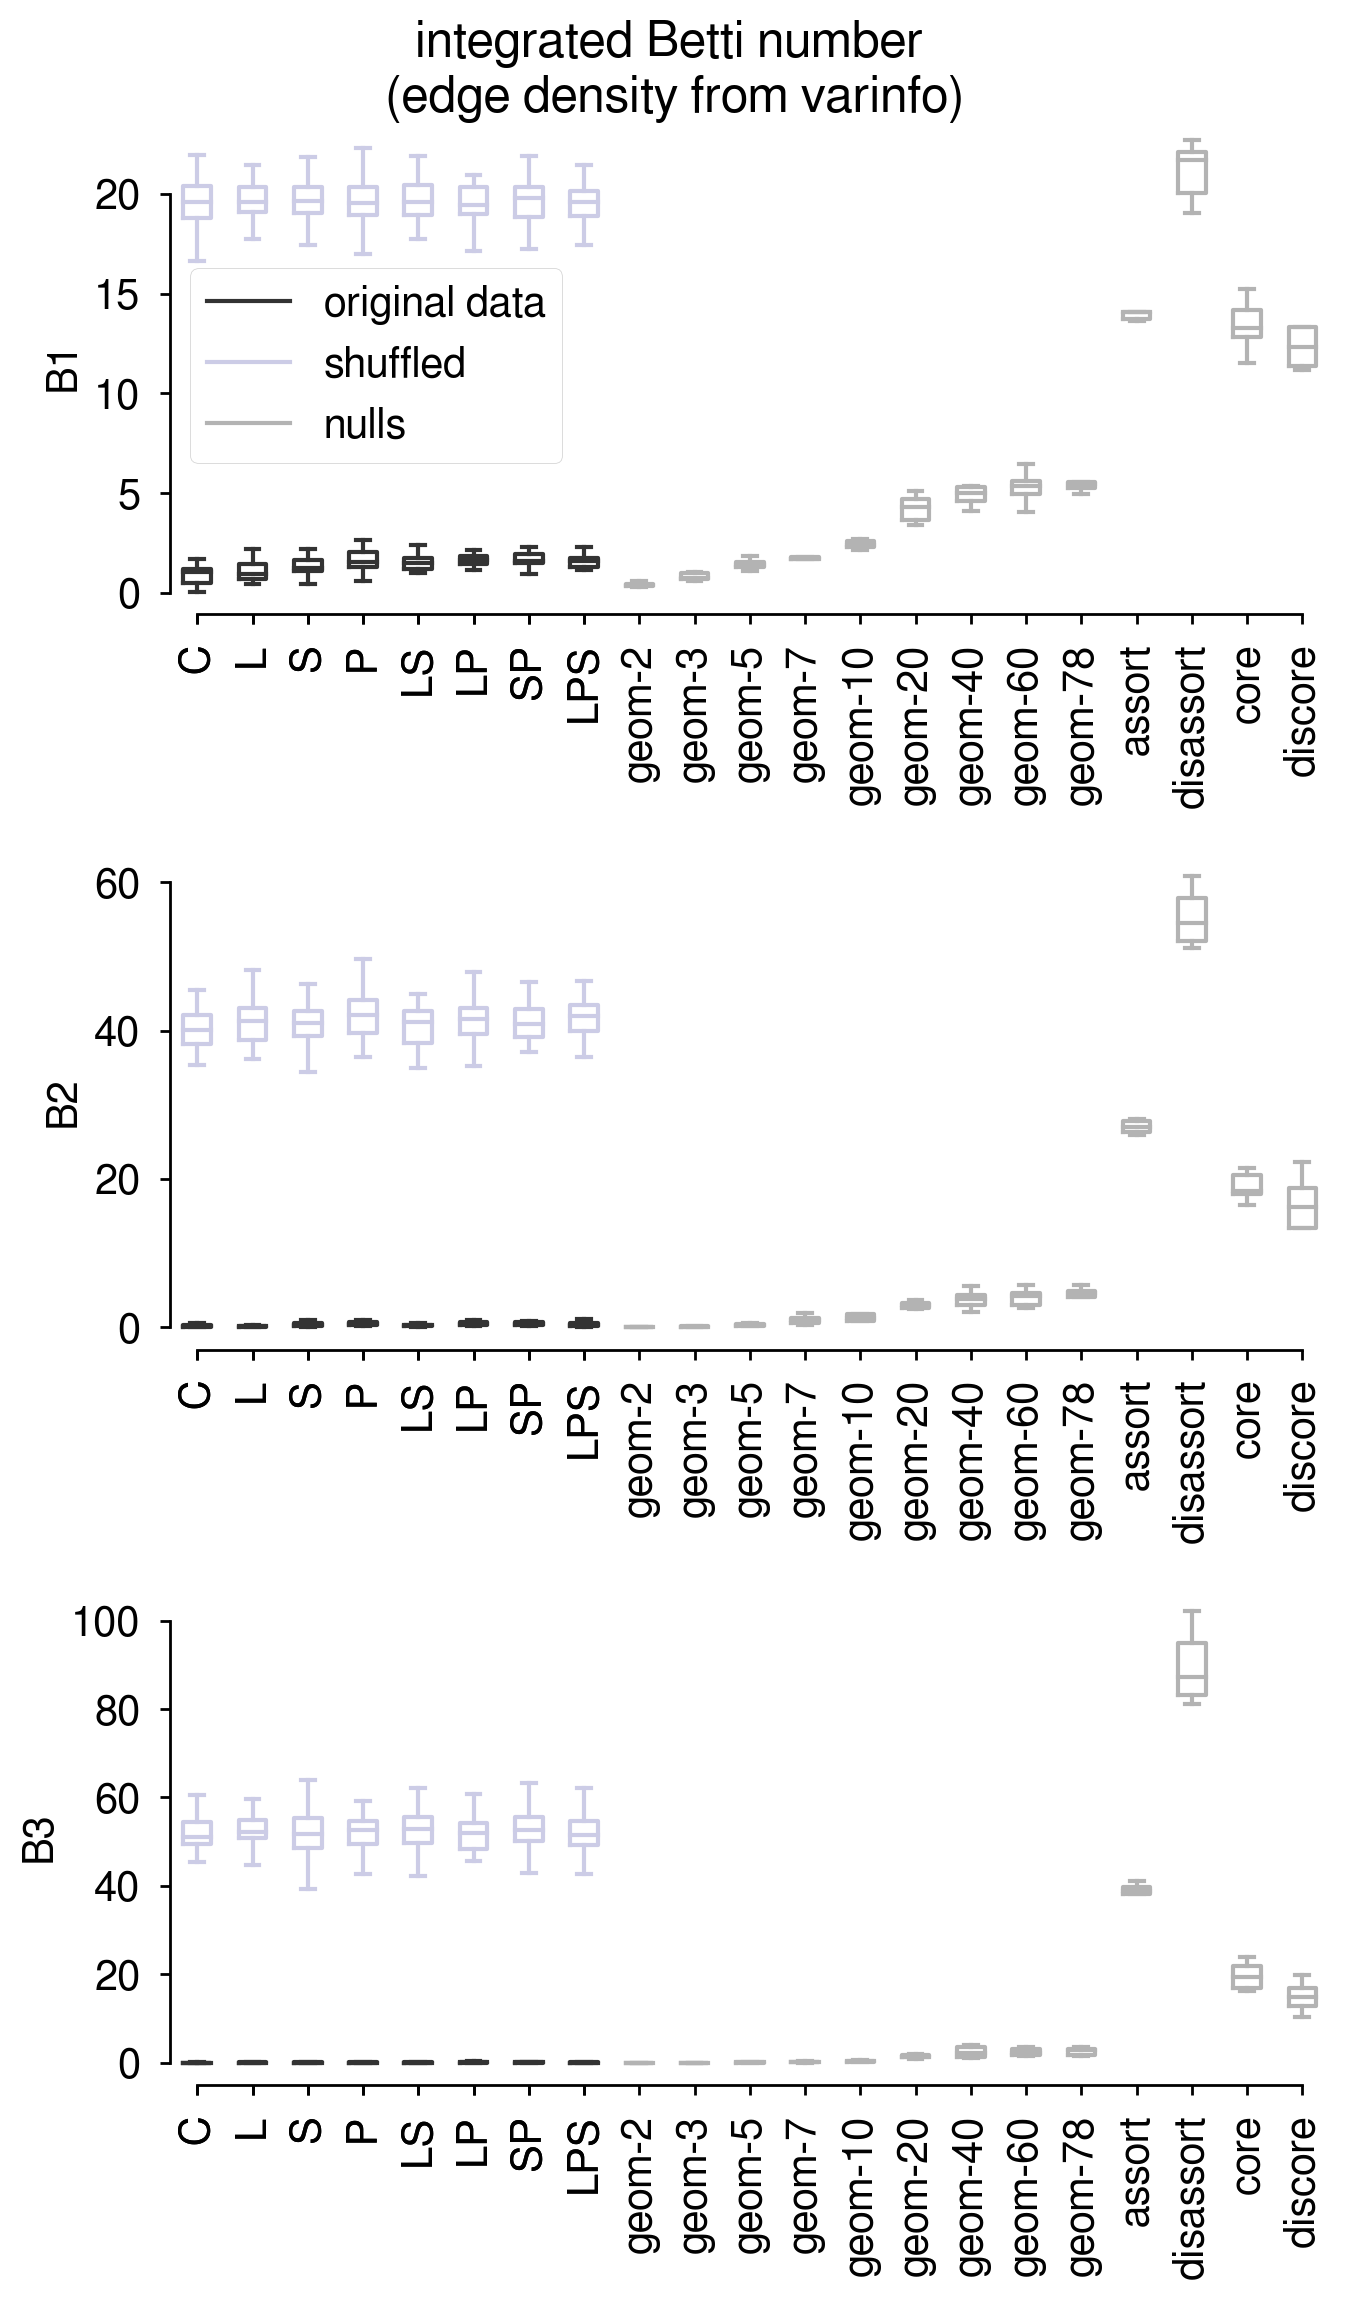

In [9]:
dat_dist_name = 'varinfo' # dat_dist_name = 'corrdist'
select_on = False # if true only plot certain geoms nulls, no shuffled, no blocks nulls

pers_names = dict(
    int_betti = 'integrated Betti number',
    mean_pers = 'mean lifetimes',
    med_pers = 'median lifetimes', 
    sum_pers = 'sum lifetimes', 
    max_pers = 'max lifetimes', 
    ent_pers = 'peristence entropy'
)

og_color = [0.2,0.2,0.2]
shuff_color = [0.8,0.8,0.9]
null_color = [0.7,0.7,0.7]
box_styles = dict(
    og    = dict(showfliers=False,
                 boxprops=dict(color=og_color,linewidth=1.5),
                 medianprops=dict(color=og_color,linewidth=1.5),
                 whiskerprops=dict(color=og_color,linewidth=1.5),
                 capprops=dict(color=og_color,linewidth=1.5)),
    shuff = dict(showfliers=False,
                 boxprops=dict(color=shuff_color,linewidth=1.5),
                 medianprops=dict(color=shuff_color,linewidth=1.5),
                 whiskerprops=dict(color=shuff_color,linewidth=1.5),
                 capprops=dict(color=shuff_color,linewidth=1.5)),
    null  = dict(showfliers=False,
                 boxprops=dict(color=null_color,linewidth=1.5),
                 medianprops=dict(color=null_color,linewidth=1.5),
                 whiskerprops=dict(color=null_color,linewidth=1.5),
                 capprops=dict(color=null_color,linewidth=1.5)),
)

og_src = 'og_%s' %(dat_dist_name)
shuff_src = 'shuff_%s' %(dat_dist_name)

null_srcs = ['geom'] if select_on else ['geom','block'] 
for cnt_fig, score_name in enumerate(pers_names.keys()):
    figsize = (5,12) if select_on else (7,12)
    plt.figure(figsize=figsize)
    for cnt_splt, pers_dim in enumerate(pers_dims):
        box_data = {'og': [], 'shuff': [], 'null': []}

        for stim in stim_types:
            box_data['og'].append(pers_scores[og_src][stim][pers_dim][score_name])
            box_data['shuff'].append(pers_scores[shuff_src][stim][pers_dim][score_name])

        null_labels = []
        for null_src in null_srcs:
            for k,v in pers_scores[null_src].items():
                if select_on: 
                    if k > 10: continue 
                box_data['null'].append(v[pers_dim][score_name])
                null_labels.append('geom-%d' %(k) if 'geom' is null_src else k)

        plt.subplot(len(pers_dims),1,cnt_splt+1)
        if select_on: 
            plt_boxes = [
                plt.boxplot(box_data['og'], labels=stim_types, **box_styles['og']),
                plt.boxplot(box_data['null'], labels=null_labels, **box_styles['null'], 
                                     positions=np.arange(len(box_data['null'])) + len(box_data['og']) + 1)
            ]
            legend_names = ['original data', 'nulls']
        else:
            plt_boxes = [
                plt.boxplot(box_data['og'], labels=stim_types, **box_styles['og']),
                plt.boxplot(box_data['shuff'], labels=stim_types, **box_styles['shuff']),
                plt.boxplot(box_data['null'], labels=null_labels, **box_styles['null'], 
                                     positions=np.arange(len(box_data['null'])) + len(box_data['og']) + 1)
            ] 
            legend_names = ['original data', 'shuffled', 'nulls']

        plt.ylabel(pers_dim)
        sns.despine(trim=True)
        plt.xticks(rotation=90)
        if cnt_splt == 0:
            plt.gca().legend([x['boxes'][0] for x in plt_boxes],legend_names)
    
    plt.suptitle('%s \n(edge density from %s)' %(pers_names[score_name],dat_dist_name),y=0.96)
    plt.tight_layout()

    fig_filename = 'figures/pers-scores/withedgedensity-%s-from-%s-%s' %(score_name,dat_dist_name,'select' if select_on else 'full')
    plt.savefig(fig_filename)
    if cnt_fig > 0:  
        plt.close()
    else: 
        plt.show()

## Compare with `varinfo` between data stimulus categories (actual distances) of persistent scores

In [10]:
proc_path = 'data/processed/'
sum_path = 'data/summary/'

pershom_files = dict(
    og_corrdist = 'multisensory-pershom-original-withdist-corr_dist.pkl',
    og_varinfo = 'multisensory-pershom-original-withdist-var_info.pkl', 
)

pershom_data = {}
for k,v in pershom_files.items():
    with open(proc_path + v, 'rb') as f: 
        pershom_data[k] = pickle.load(f)

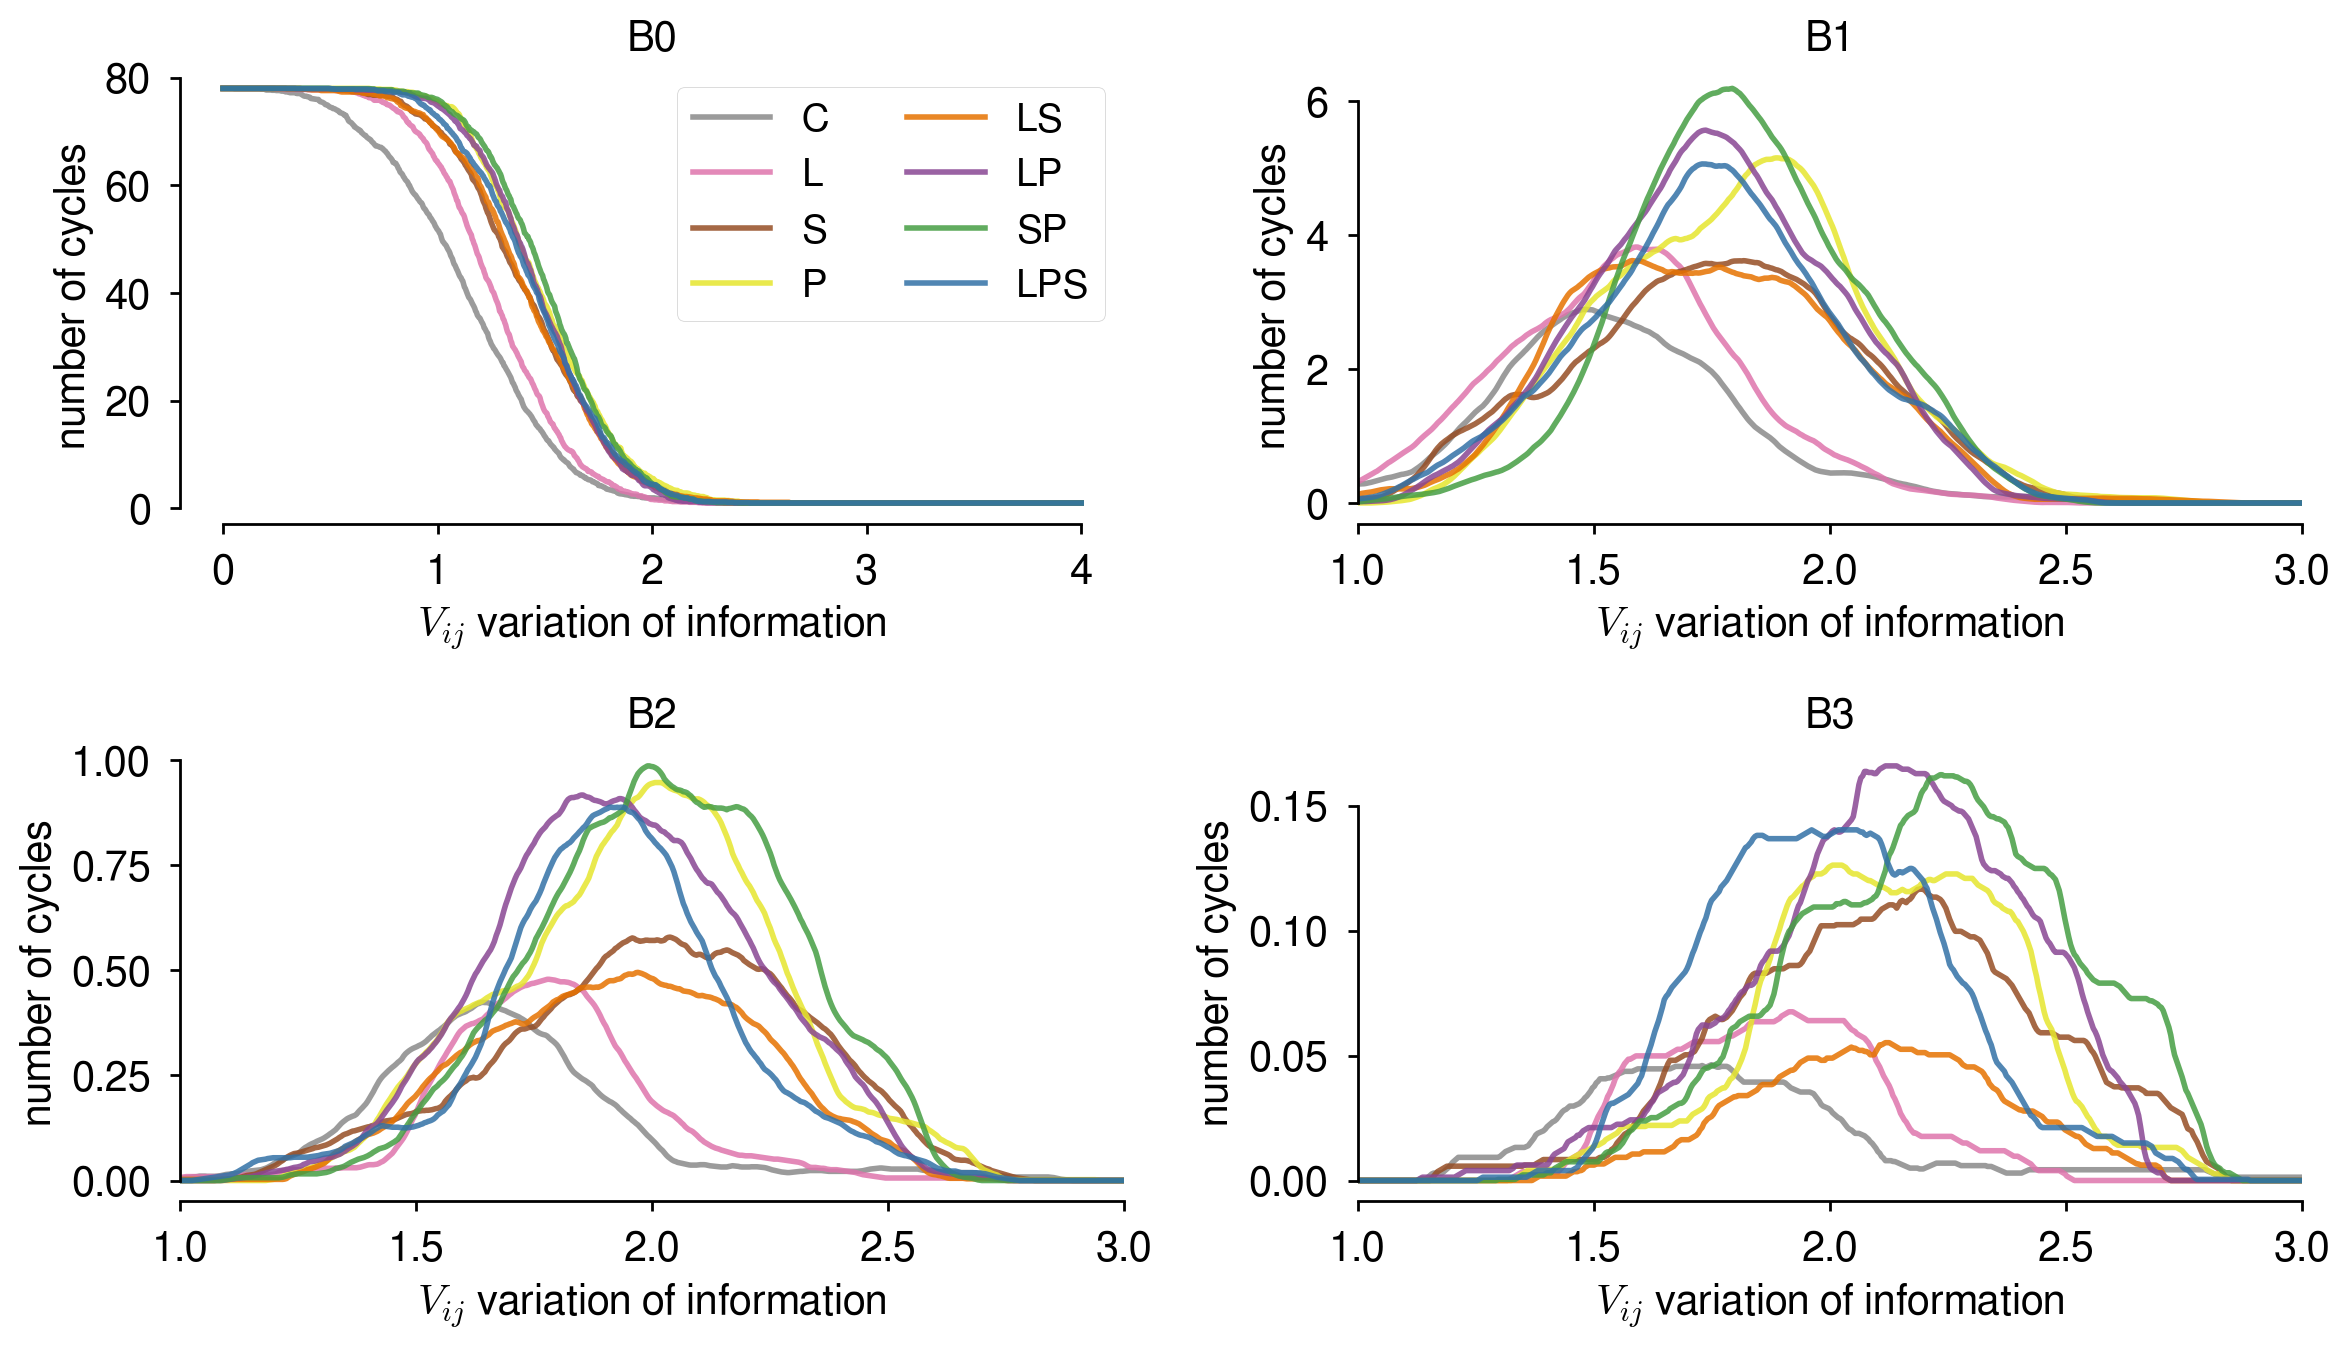

In [11]:
cmap_types = dict(
    og_corrdist = 'Set1_r',
    og_varinfo = 'Set1_r'
)


data_key = 'og_varinfo'

plt.figure(figsize=(12,7))

for cnt_b, b_key in enumerate(['B0', 'B1', 'B2', 'B3']):
    
    plt.subplot(2,2,cnt_b+1)
    
    bar_feats = pershom_data[data_key]['barfeats']
    vec_rhos = pershom_data[data_key]['vec_rhos']

    num_vars = len(bar_feats)

    cmap = plt.get_cmap(cmap_types[data_key]) 
    colors = cmap(np.arange(num_vars)/num_vars) * 0.9 

    for cnt, (var, bar_feat) in enumerate(bar_feats.items()):
        plt.plot(vec_rhos, smooth(np.mean(bar_feat[b_key]['betti_num'],axis=0),(cnt_b)*25),
                  c=colors[cnt,:],linewidth=2,alpha=0.85, label='%s' %(var))
    if cnt_b == 0:
        plt.legend(fontsize=14, ncol=2)
    else:
        plt.xlim([1,3])

    plt.xlabel('$V_{ij}$ variation of information')
    plt.ylabel('number of cycles')

    plt.title(b_key)
    sns.despine(trim=True)
        
plt.tight_layout()
plt.show()

In [12]:
betti_curves = {}
pers_scores = {}
pers_summary = {}

for k,v in pershom_data.items():
    betti_nums = {ki: {kj:vj['betti_num'] for kj,vj in vi.items()}
                  for ki,vi in v['barfeats'].items()}
    pers_scores[k] = {ki: {kj: {xk : xv.flatten() for xk,xv in vj.items()
                             if xk != 'betti_num'}
                      for kj,vj in vi.items()}
                  for ki,vi in v['barfeats'].items()}
    
    betti_curves[k] = {
        ki: {kj: 
             dict(mean = np.mean(vj,axis=0),
                  sem  = np.std(vj,axis=0)/np.sqrt(vj.shape[0])) 
             for kj, vj in vi.items()}
        for ki,vi in betti_nums.items()}

for k0,v0 in pers_scores.items():
    for k1,v1 in v0.items():
        for k2,v2 in v1.items():
            pers_summary['%s-%s-%s' %(k0,k1,k2)] = {
                xk: np.mean(xv) for xk, xv in v2.items()
            }

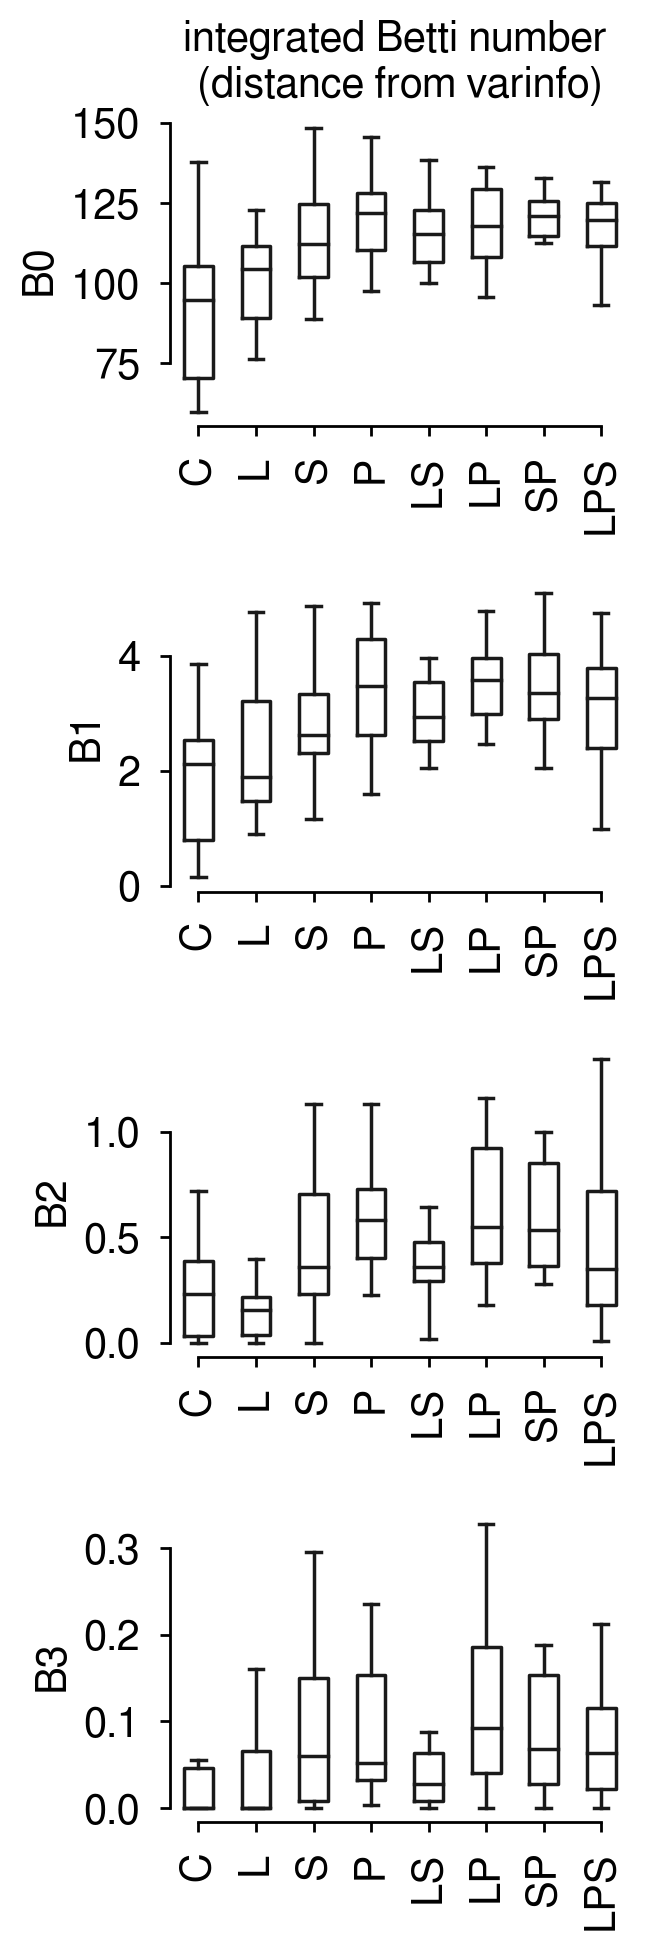

In [13]:
dat_dist_name = 'varinfo'
og_src = 'og_%s' %(dat_dist_name)
shuff_src = 'shuff_%s' %(dat_dist_name)

stim_types = ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS']

og_color = [0.1,0.1,0.1]
box_styles = dict(
    showfliers=False,
    boxprops=dict(color=og_color,linewidth=1.25),
    medianprops=dict(color=og_color,linewidth=1.25),
    whiskerprops=dict(color=og_color,linewidth=1.25),
    capprops=dict(color=og_color,linewidth=1.25))

pers_dims = ['B0', 'B1', 'B2', 'B3']

for cnt_fig, score_name in enumerate(pers_names.keys()):
    plt.figure(figsize=(3.5,10))
    for cnt, pers_dim in enumerate(pers_dims):
        box_data = {'og': [], 'shuff': [], 'null': []}

        for stim in stim_types:
            box_data['og'].append(pers_scores[og_src][stim][pers_dim][score_name])

        plt.subplot(len(pers_dims),1,cnt+1)
        plt.boxplot(box_data['og'], labels=stim_types, **box_styles)
        plt.ylabel(pers_dim)
        sns.despine(trim=True)
        plt.xticks(rotation=90)
        
        if cnt == 0:
            plt.title('%s \n(distance from %s)' %(pers_names[score_name],dat_dist_name))
    plt.tight_layout()

    fig_filename = 'figures/pers-scores/withdist-%s-from-%s-%s' %(score_name,dat_dist_name,
                                                                  'select' if select_on else 'full')
    plt.savefig(fig_filename)
    if cnt_fig > 0:
        plt.close()
    else: 
        plt.show()